In [1]:
import numpy as np
import notebooks.src.visualizingrestatements.visualizingrestatements as vs
import datetime as dt
import pandas as pd
import time
import sys
import os
from contextlib import contextmanager
from io import StringIO
from collections import defaultdict
from botocore.config import Config
from stations.station import df_from_s3_csv, df_to_s3_csv
import matplotlib.pyplot as plt
import matplotlib.ticker as mtk
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from math import ceil
import boto3
import re
import notebooks.src.metrics.metrics as m
from collections import OrderedDict
from scipy.stats import sem

# Get Data

In [2]:
ACCESS_KEY_ID = # add yours here
SECRET_ACCESS_KEY = # add yours here
creds_dict = {
    'aws_access_key_id': ACCESS_KEY_ID,
    'aws_secret_access_key': SECRET_ACCESS_KEY,
    'region_name': "us-west-2",
    'config': Config(s3={"use_accelerate_endpoint": True})
}
client = boto3.client('s3')

result = client.list_objects(Bucket='us-formatted-data', Prefix='JHU/US/', Delimiter='/')

vals =  [ res.get('Prefix') for res in result.get('CommonPrefixes') ]

states = ["Alabama",
"Alaska",
"Arizona",
"Arkansas",
"California",
"Colorado",
"Connecticut",
"Delaware",
"Florida",
"Georgia",
"Hawaii",
"Idaho",
"Illinois",
"Indiana",
"Iowa",
"Kansas",
"Kentucky",
"Louisiana",
"Maine",
"Maryland",
"Massachusetts",
"Michigan",
"Minnesota",
"Mississippi",
"Missouri",
"Montana",
"Nebraska",
"Nevada",
"New Hampshire",
"New Jersey",
"New Mexico",
"New York",
"North Carolina",
"North Dakota",
"Ohio",
"Oklahoma",
"Oregon",
"Pennsylvania",
"Rhode Island",
"South Carolina",
"South Dakota",
"Tennessee",
"Texas",
"Utah",
"Vermont",
"Virginia",
"Washington",
"West Virginia",
"Wisconsin",
"Wyoming"]

state_buckets = [state for state in vals if state.replace("JHU/US/", "").replace("/", "") in states ]
start, stop = '2020-02-14','2022-06-11'

COL = "deaths"
REGION = "California"
data_title = f'{COL.title()} in {REGION}'

def get_df(state, col):

    dates = pd.date_range(start=start, end=stop)
    df = df_from_s3_csv(bucket='us-formatted-data', key=f'JHU/US/{state}//{col}/data.csv', **creds_dict)
    df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
    df.columns = pd.to_datetime(df.columns, format="%Y-%m-%d")
    adj_df = pd.DataFrame(columns=dates, index=dates)
    adj_df.update(df)

    return adj_df

dfs_dict = {
    state :
    get_df(state = state, col = COL)
    for state in states
}
arrays_dict  = {key: df.to_numpy( na_value=np.nan) for key, df in dfs_dict.items()}

df = dfs_dict[REGION]
X = df.to_numpy( na_value = np.nan)

path = '../latex/plots/metrics/JHU_{region}_{metric}.png'

Attempting to read S3 object JHU/US/Alabama//deaths/data.csv in us-formatted-data
Successfully read S3 object JHU/US/Alabama//deaths/data.csv in us-formatted-data
Attempting to read S3 object JHU/US/Alaska//deaths/data.csv in us-formatted-data
Successfully read S3 object JHU/US/Alaska//deaths/data.csv in us-formatted-data
Attempting to read S3 object JHU/US/Arizona//deaths/data.csv in us-formatted-data
Successfully read S3 object JHU/US/Arizona//deaths/data.csv in us-formatted-data
Attempting to read S3 object JHU/US/Arkansas//deaths/data.csv in us-formatted-data
Successfully read S3 object JHU/US/Arkansas//deaths/data.csv in us-formatted-data
Attempting to read S3 object JHU/US/California//deaths/data.csv in us-formatted-data
Successfully read S3 object JHU/US/California//deaths/data.csv in us-formatted-data
Attempting to read S3 object JHU/US/Colorado//deaths/data.csv in us-formatted-data
Successfully read S3 object JHU/US/Colorado//deaths/data.csv in us-formatted-data
Attempting to 

Successfully read S3 object JHU/US/Wyoming//deaths/data.csv in us-formatted-data


In [3]:
#  make a barchart across the deaths
RELEASE = '2021-10-19'
OBSV = '2021-10-18'
state_data = {}

for state, sdf in dfs_dict.items():
    state_data[state] = {OBSV: sdf.loc[OBSV, RELEASE]}



In [4]:
plt.clf()

<Figure size 432x288 with 0 Axes>

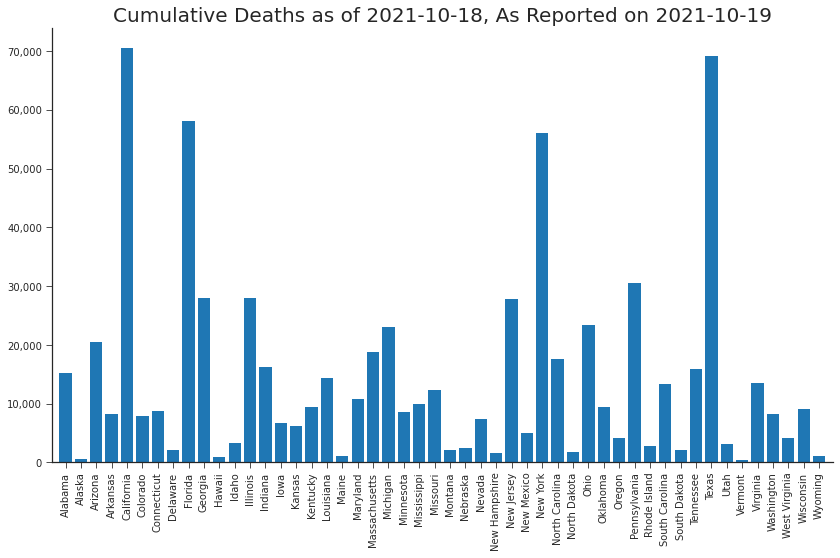

In [5]:
temp_df = pd.DataFrame(state_data).T

title = f'As Reported on {RELEASE}'
x_label = ""
y_label = ""

plt, axs, setup_dct =  vs.setup_plot(
    temp_df, title, f'Cumulative Deaths as of {OBSV}', x_label, y_label,
    nrows=1, ncols=1, y_scale="linear", figsize=(14,8)
)

plt.bar(x= temp_df.index, height = temp_df[OBSV])
plt.title(label=f'Cumulative Deaths as of {OBSV}, ' + title, fontsize=20)
plt. margins(x=.01)

axs.get_yaxis().set_major_formatter(
    mtk.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.savefig(path.format(region="US_States", metric='total'),  bbox_inches="tight")

# Accuracy 

In [6]:
offsets = [30, 90, 150, 365]
naive_accuracy_dm = m.naive_accuracy(X, X.shape[1] - 1)
accuracy_dms = [ m.offset_accuracy(X, i) for i in offsets]

col_names = [*[ f'{each}'  for each in offsets] , "latest release"]
accuracy_df = pd.DataFrame([  *accuracy_dms, naive_accuracy_dm], columns=df.index[:-1], index=col_names ).T

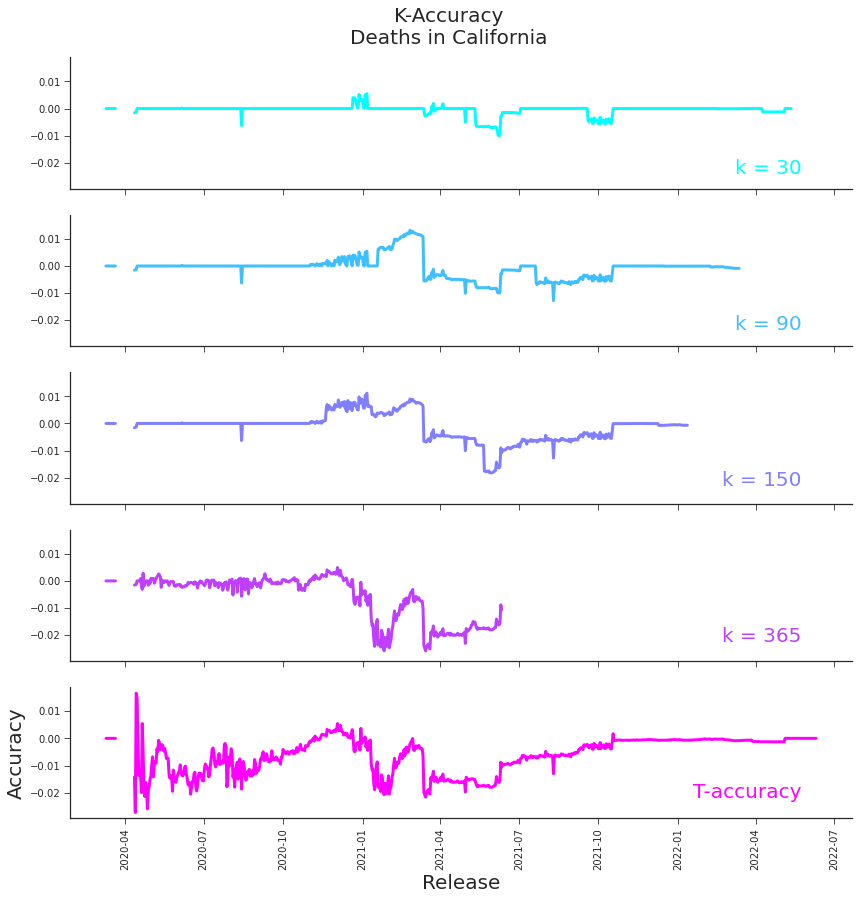

In [7]:
title = "K-Accuracy" + "\n" + data_title
x_label = "Release"
y_label = "Accuracy"

plt, axs, setup_dct =  vs.setup_plot(
    accuracy_df, "", "", x_label, y_label,
    nrows=accuracy_df.shape[1], ncols=1, y_scale="linear", figsize=(14,14)
)

colors = plt.cm.cool(np.linspace(0, 1, len(accuracy_df.columns)))

for i, col in enumerate(accuracy_df.columns):
    axs[i, 0].plot( accuracy_df[col], color=colors[i])

    plt.gcf().text(0.85, 0.765 - .155*i, (i!=4)*f'k = {col}' + (i==4)*"T-accuracy",
        horizontalalignment='right',
        color=colors[i], fontsize=20)

plt.suptitle(title, fontsize=20, y=.93)
plt.savefig(path.format(region=REGION, metric='accuracy'),  bbox_inches="tight")

## Select States

In [8]:
def get_accuracy(list_of_states):
    adf_dict = {}
    for state in list_of_states:
        X = arrays_dict[state]
        naive_accuracy_dm = m.naive_accuracy(X, X.shape[1] - 1)
        accuracy_dms = [ m.offset_accuracy(X, i) for i in offsets]

        col_names = [*[ f'{each}'  for each in offsets] ,  "latest release"]
        accuracy_df = pd.DataFrame([  *accuracy_dms, naive_accuracy_dm], columns=df.index[:-1], index=col_names ).T
        adf_dict[state] = accuracy_df

    return adf_dict

In [9]:
acc_dct = get_accuracy(dfs_dict.keys())

In [10]:
temp_states = pd.DataFrame(
    { state: {"avg" : abs(adf.mean()["latest release"])} for state, adf in acc_dct.items()}
    ).T.sort_values("avg", ascending=False)[:-1].index

In [11]:
temp_states = temp_states.to_list()[:4]
temp_states[0] = 'California'

In [12]:
temp_states

['California', 'Ohio', 'Delaware', 'Rhode Island']

In [13]:
accuracy_estimates = m.accuracy_estimates_all(accuracy_df.iloc[:, :-1], accuracy_df.index)

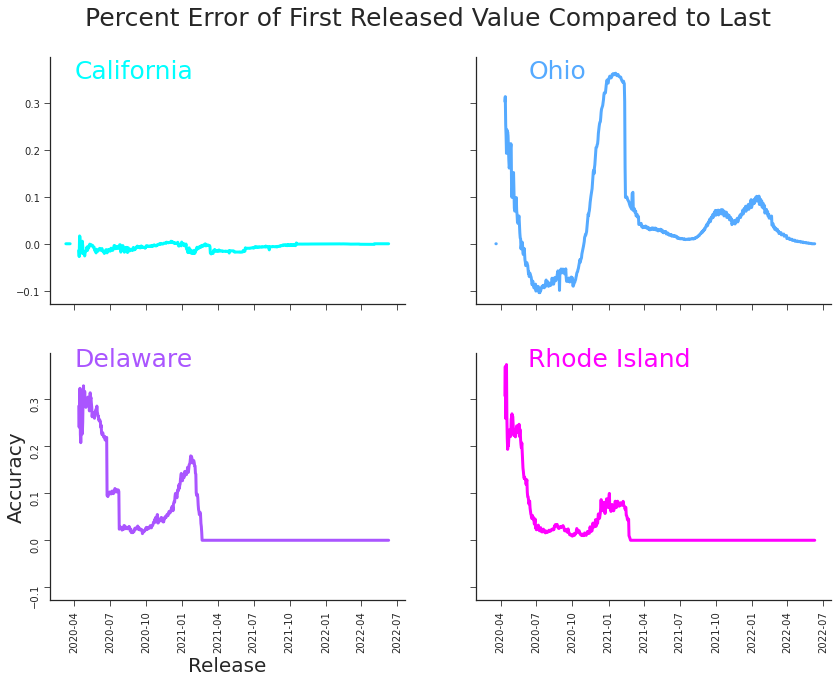

In [14]:
title = "Percent Error of First Released Value Compared to Last"
x_label = "Release"
y_label = "Accuracy"

plt, axs, setup_dct =  vs.setup_plot(
    acc_dct[temp_states[0]], title, "", x_label, y_label,
    nrows=2, ncols=2, y_scale="linear", figsize=(14,10)
)

colors = plt.cm.cool(np.linspace(0, 1, len(temp_states)))

i = 0
locs = [(0,0), (0,1), (1,0), (1,1)]
title_locs = [(.15, .85), (.6, .85), (.15, .45), (.6, .45)]
for state in temp_states:
    loc = locs[i]
    axs[loc].plot(acc_dct[state]['latest release'], c=colors[i])

    plt.gcf().text(
        title_locs[i][0], title_locs[i][1],
        state,
        color=colors[i],
        fontsize=25
    )
    i+=1
plt.suptitle(title, fontsize=25, y=0.95)
axs[1,0].tick_params(labelrotation=90)

plt.savefig(path.format(region="US_States", metric='naive_accuracy'),  bbox_inches="tight")

## Accuracy Estimates

In [15]:
def accuracy_mr_impact_plots(region, **kwargs):

    accuracy_df = acc_dct[region]
    X = arrays_dict[region]
    accuracy_estimates = m.accuracy_estimates_all(accuracy_df.iloc[:, :-1], accuracy_df.index)
    # performance = m.diff_matrix(accuracy_df.iloc[:, :-1].to_numpy() , offsets, df.index[:-min(offsets)])
    restatement_dct = m.major_restatements_all(X, df.index, **kwargs)
    restatement_df = pd.DataFrame(restatement_dct).T
    mrs = restatement_df[restatement_df['major_restatement']].index

    title = "Performance of Accuracy Estimates"
    x_label = "Release"
    y_label = "Accuracy"

    plt, axs, setup_dct =  vs.setup_plot(
        accuracy_estimates, title, data_title, x_label, y_label,
        nrows=accuracy_estimates.shape[1], ncols=1, y_scale="linear", figsize=(14,10)
    )
    
    colors = plt.cm.cool(np.linspace(0, 1, accuracy_estimates.shape[1]))
    colors_mr = plt.cm.hsv(np.linspace(0, 1, len(mrs) + 3))
    releases = accuracy_estimates.index.to_list()
    print(mrs)

    for i, col in enumerate(accuracy_estimates.columns):

        for j, mr in enumerate(mrs):

            ind_loc = releases.index(mr)
            ind_lhs = max(0, ind_loc - int(col))
            lhs = releases[ind_lhs]

            axs[i, 0].plot( [lhs, mr], [-.025 + .0015 , -.025+ .0015], color=colors_mr[j], alpha=0.4)
            axs[i, 0].plot( [lhs, mr], [.025 + .0015 , .025+ .0015], color=colors_mr[j], alpha=0.4)
            axs[i, 0].plot( [lhs, lhs], [-.025 + .0015 , .025+ .0015], color=colors_mr[j], alpha=0.4)        
            axs[i, 0].plot( [mr, mr], [-.025 + .0015 , .025+ .0015], color=colors_mr[j], alpha=0.4)

        c = colors[i]
        axs[i, 0].plot( accuracy_df[col], color='grey')

        plt.gcf().text(0.15, 0.725 - .195*i, f'k = {col}',
            horizontalalignment='left',
            color='grey',# colors[i],
            fontsize=20)

    for j, mr in enumerate(mrs):

        plt.gcf().text(0.3 + .1*j, 0.9, mr.strftime('%Y-%m-%d'),
            horizontalalignment='right',
            color=colors_mr[j], fontsize=15)
        
        if j > 5:
            break
    
    
    plt.suptitle(f'Impact Window of Major Restatements on Accuracy\nDeaths in {region}', fontsize=20)
    plt.savefig(path.format(region=region, metric='accuracy_mr_impact'),  bbox_inches="tight")



DatetimeIndex(['2021-04-19', '2021-06-11', '2021-07-07', '2021-10-19',
               '2022-03-17', '2022-05-09'],
              dtype='datetime64[ns]', freq=None)


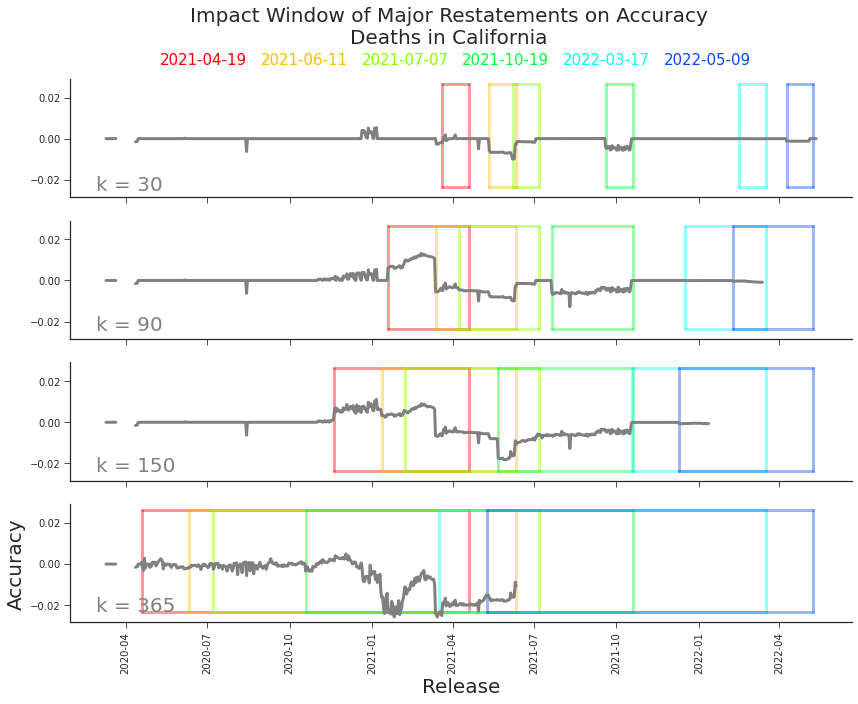

In [16]:

accuracy_mr_impact_plots("California")


In [17]:
restatement_dct = m.major_restatements_all(X, df.index)
restatement_df = pd.DataFrame(restatement_dct).T
mrs = restatement_df[restatement_df['major_restatement']].index

In [18]:
mrs

DatetimeIndex(['2021-04-19', '2021-06-11', '2021-07-07', '2021-10-19',
               '2022-03-17', '2022-05-09'],
              dtype='datetime64[ns]', freq=None)

In [19]:
restatement_df['percent'][restatement_df['percent'] > .2]

2021-04-19    0.776224
2021-06-11    0.792531
2021-07-07    0.824803
2021-10-19    0.897059
2022-03-17    0.604468
2022-05-09    0.912776
Name: percent, dtype: object

In [20]:
def accuracy_performance_plots(region, history=60):

    accuracy_df = acc_dct[region]
    accuracy_estimates = m.accuracy_estimates_all(accuracy_df.iloc[:, :-1], accuracy_df.index, history=history)
    restatement_dct = m.major_restatements_all(X, df.index)
    restatement_df = pd.DataFrame(restatement_dct).T
    mrs = restatement_df[restatement_df['major_restatement']].index

    title = "Performance of Accuracy Estimates"
    x_label = "Release"
    y_label = "Accuracy"



    plt, axs, setup_dct =  vs.setup_plot(
        accuracy_estimates, title, data_title, x_label, y_label,
        nrows=accuracy_estimates.shape[1], ncols=1, y_scale="linear", figsize=(14,10)
    )
    colors = plt.cm.cool(np.linspace(0, 1, accuracy_estimates.shape[1]))
    colors_mr = plt.cm.hsv(np.linspace(0, 1, len(mrs) + 1))
    releases = accuracy_estimates.index.to_list()

    for i, col in enumerate(accuracy_estimates.columns):


        c = colors[i]
        axs[i, 0].plot( accuracy_df[col], color='grey')
        axs[i, 0].plot( accuracy_estimates[col], color='violet')

        plt.gcf().text(0.15, 0.725 - .195*i, f'k = {col}',
            horizontalalignment='left',
            color='grey',# colors[i],
            fontsize=20)

    plt.gcf().text(0.85, 0.85, 'estimated accuracy',
        horizontalalignment='right',
        color='violet', fontsize=20)
    plt.gcf().text(0.845, 0.88, 'observed accuracy',
        horizontalalignment='right',
        color='grey', fontsize=20)
    

    print(mrs)
    
    plt.suptitle(f'Using the Average Accuracy of {history} Prior Releases to Estimate Accuracy\nDeaths in California', fontsize=20)
    plt.savefig(path.format(region=region, metric='perf_accuracy_estimates'),  bbox_inches="tight")



DatetimeIndex(['2021-04-19', '2021-06-11', '2021-07-07', '2021-10-19',
               '2022-03-17', '2022-05-09'],
              dtype='datetime64[ns]', freq=None)


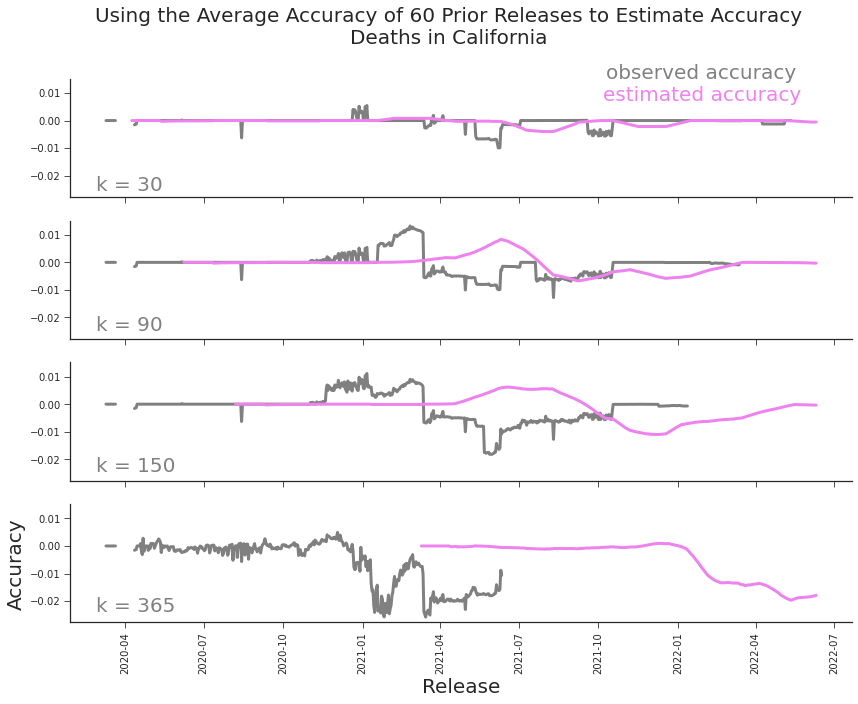

In [21]:
accuracy_performance_plots(REGION)

In [22]:
accuracy_df.iloc[:,:-1]

,30,90,150,365
2020-02-14,NaN,NaN,NaN,NaN
2020-02-15,NaN,NaN,NaN,NaN
2020-02-16,NaN,NaN,NaN,NaN
2020-02-17,NaN,NaN,NaN,NaN
2020-02-18,NaN,NaN,NaN,NaN
...,...,...,...,...
2022-06-06,NaN,NaN,NaN,NaN
2022-06-07,NaN,NaN,NaN,NaN
2022-06-08,NaN,NaN,NaN,NaN
2022-06-09,NaN,NaN,NaN,NaN


# Timeliness and Accuracy

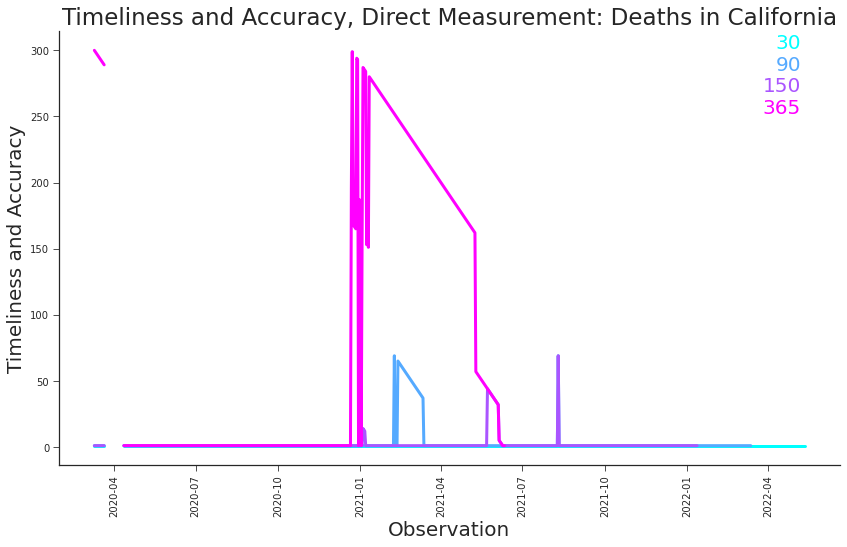

In [23]:
vals = [ m.timeliness_and_accuracy_all(X, i, .01) for i in offsets]
col_names = [f'{offset}' for offset in offsets]

timeliness_and_accuracy_df = pd.DataFrame(vals, columns=df.index[:-min(offsets)], index= col_names).T

title = "Timeliness and Accuracy, Direct Measurement"
x_label = "Observation"
y_label = "Timeliness and Accuracy"


plt, axs, setup_dct =  vs.setup_plot(
    timeliness_and_accuracy_df, title, data_title, x_label, y_label,
    nrows=1, ncols=1, y_scale="linear", figsize=(14,8)
)

for i, col in enumerate(timeliness_and_accuracy_df.columns):
    plt.plot( timeliness_and_accuracy_df[col], color=colors[i])

    axs.text(0.95, 0.95 - .05*i, col,
        verticalalignment='bottom', horizontalalignment='right',
        transform=axs.transAxes,
        color=colors[i], fontsize=20)

plt.savefig(path.format(region=REGION, metric='timeliness_and_accuracy'),  bbox_inches="tight")

## Timeliness and Accuracy Estimates

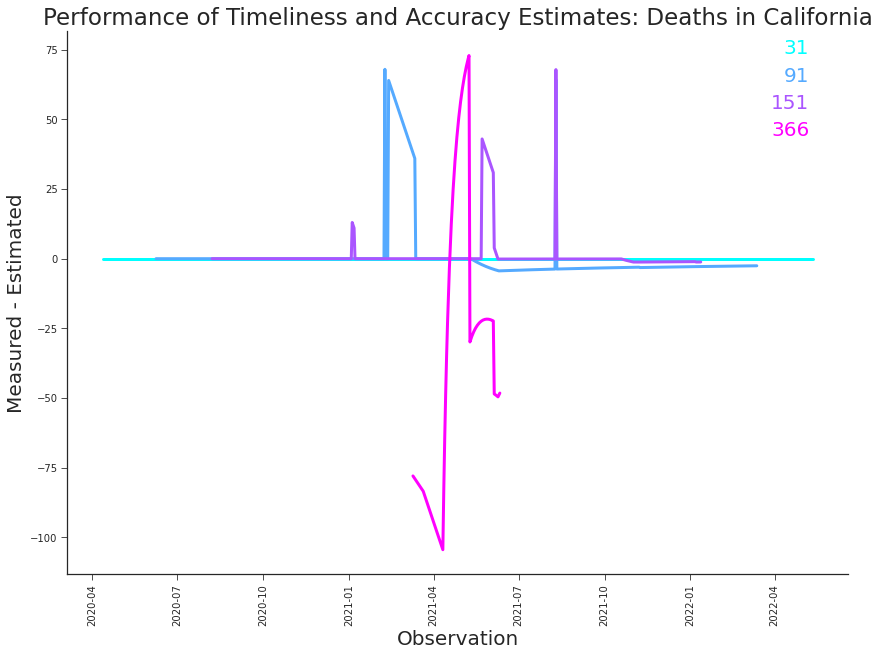

In [24]:
taa_estimates = m.accuracy_estimates_all(timeliness_and_accuracy_df, timeliness_and_accuracy_df.index)
performance_taa = m.diff_matrix(vals, offsets, df.index[:-min(offsets)])

title = "Performance of Timeliness and Accuracy Estimates"
x_label = "Observation"
y_label = "Measured - Estimated"


plt, axs, setup_dct =  vs.setup_plot(
    performance_taa, title, data_title, x_label, y_label,
    nrows=1, ncols=1, y_scale="linear", figsize=(14,10)
)

for i, col in enumerate(performance_taa.columns):
    plt.plot( performance_taa[col], color=colors[i])

    axs.text(0.95, 0.95 - .05*i, int(col)+1,
        verticalalignment='bottom', horizontalalignment='right',
        transform=axs.transAxes,
        color=colors[i], fontsize=20)

plt.savefig(path.format(region=REGION, metric='perf_timeliness_and_accuracy_estimates'),  bbox_inches="tight")

# Completeness and Timeliness

In [25]:
vals = [m.completeness_and_timeliness(X[:, i], i) for i in range(1, X.shape[1]) ]
completeness_and_timeliness_df = pd.DataFrame([vals], index=[REGION], columns=df.columns[1:]).T

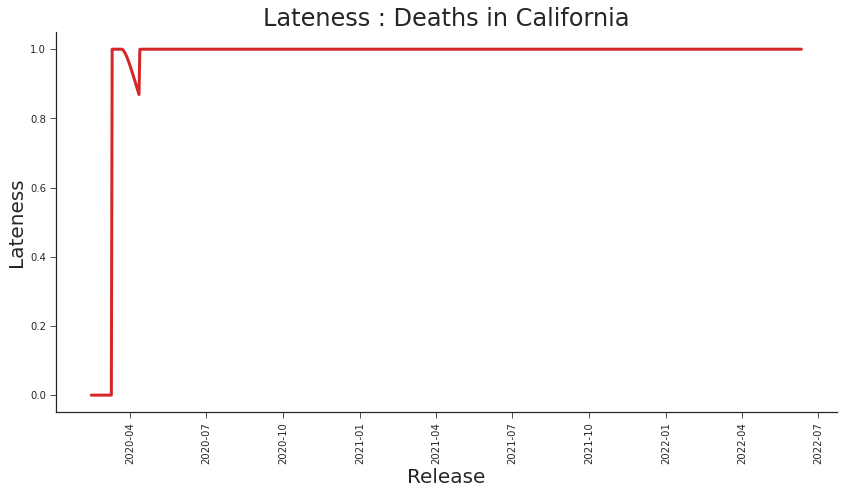

In [26]:
title = "Completeness and Timeliness"
x_label = "Release"
y_label = "Lateness"

plt, axs, setup_dct =  vs.setup_plot(
    completeness_and_timeliness_df, title, data_title, x_label, y_label,
    nrows=1, ncols=1, y_scale="linear", figsize=(14,7)
)

plt.title(label="Lateness : Deaths in California")

plt.plot(completeness_and_timeliness_df, color="tab:red")

plt.savefig(path.format(region=REGION, metric='lateness'),  bbox_inches="tight")

# Completeness

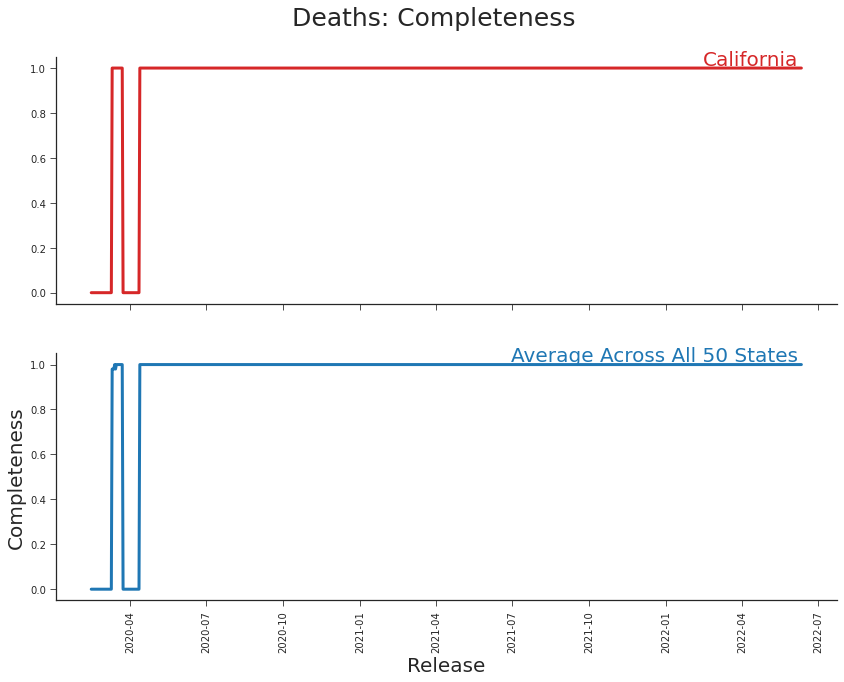

In [27]:
completeness_all_df = m.completeness_group_all(arrays_dict , dfs_dict )
completeness_df = m.completeness_group_all({ REGION: arrays_dict[REGION]} , {REGION:dfs_dict[REGION]} )
completeness_df.columns = [REGION]
completeness_df['Average Across All 50 States'] = completeness_all_df['Completeness']


title = "Deaths"
x_label = "Release"
y_label = "Completeness"


plt, axs, setup_dct =  vs.setup_plot(
    completeness_df , title, "Completeness", x_label, y_label,
    nrows=2, ncols=1, y_scale="linear", figsize=(14,10)
)

plt.suptitle(title + ": Completeness", y=.95, fontsize=25)

comparison_colors = ['tab:red', 'tab:blue']

for i, col in enumerate(completeness_df.columns):
    axs[i, 0].plot( completeness_df [col], color=comparison_colors[i])

    axs[i, 0].text(0.95, 0.95, col,
        verticalalignment='bottom', horizontalalignment='right',
        transform=axs[i, 0].transAxes,
        color=comparison_colors[i], fontsize=20)

plt.savefig(path.format(region=REGION, metric='completeness'),  bbox_inches="tight")


# Consistency Major Restatements 

In [28]:
major_restatements_df = m.major_restatements_group_all(arrays_dict , dfs_dict) #, alpha=0, beta=.01)
mrs = major_restatements_df.loc[~((major_restatements_df['percent'] == 0))]

In [29]:
mr_df = pd.DataFrame(major_restatements_df[major_restatements_df['region'] == REGION])
mr_df.set_index('release', inplace=True)

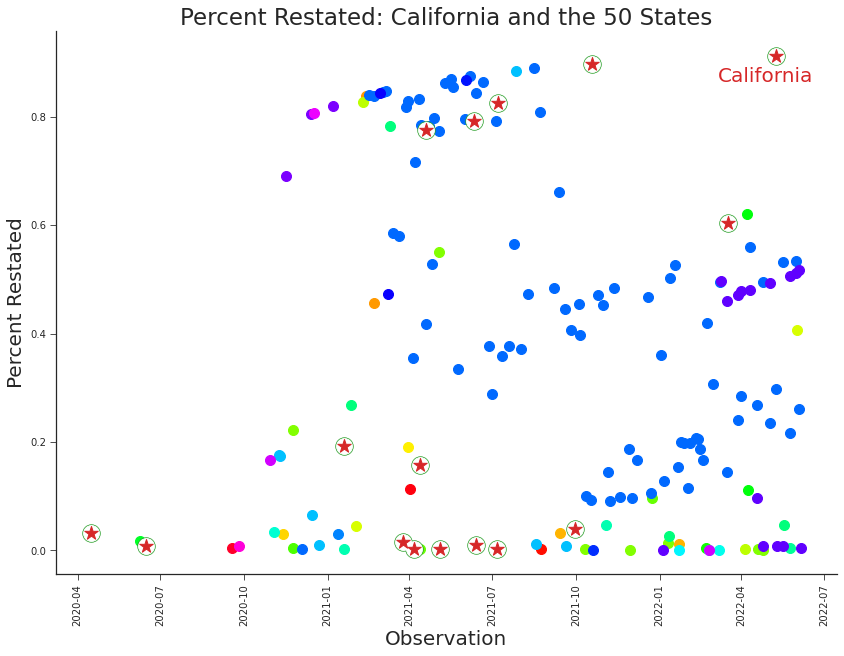

In [30]:
state_colors = plt.cm.gist_rainbow(np.linspace(0, 1, len(arrays_dict.keys())))
state_colors = {region: [ c for c in  color] for region, color in zip(arrays_dict.keys(), state_colors) }

title = "Percent Restated"
x_label = "Observation"
y_label = "Percent Restated"


plt, axs, setup_dct =  vs.setup_plot(
    mrs, title, "California and the 50 States", x_label, y_label,
    nrows=1, ncols=1, y_scale="linear", figsize=(14,10)
)

for i, state in enumerate(states):
    color = state_colors[state]
    plt.scatter(
        x=mrs[mrs['region'] == state]['release'],
        y=mrs[mrs['region'] == state]['percent'], 
        color=color)

plt.text(0.97, 0.9, REGION,
    verticalalignment='bottom', horizontalalignment='right',
    transform=axs.transAxes,
    color="tab:red", fontsize=20)

plt.scatter(
    x=mrs[mrs['region'] == REGION]['release'],
    y=mrs[mrs['region'] == REGION]['percent'], 
    color='tab:green', s=300)
plt.scatter(
    x=mrs[mrs['region'] == REGION]['release'],
    y=mrs[mrs['region'] == REGION]['percent'], 
    color='white', s=250)
plt.scatter(
    x=mrs[mrs['region'] == REGION]['release'],
    y=mrs[mrs['region'] == REGION]['percent'], 
    color='tab:red', s=200, marker='*')

plt.savefig(path.format(region=REGION, metric='percent_revised'),  bbox_inches="tight")

In [31]:
mrs.groupby('region').sum().sort_values('percent', ascending=False)

,major_restatement,percent,number
region,,,
Ohio,64,38.014528,20712
California,6,5.269637,3058
Tennessee,9,4.542958,3618
Texas,3,2.315761,702
New York,1,1.329485,595
Rhode Island,2,1.317195,503
Delaware,2,1.294455,474
Missouri,2,1.124749,456
Pennsylvania,1,0.866808,410


## Consistency Major Restatements Concurrence

In [32]:
cnc = m.consistency_mr_concurrence(arrays_dict , dfs_dict, alpha=0.0, beta = .2)
cnc = pd.DataFrame(cnc).T

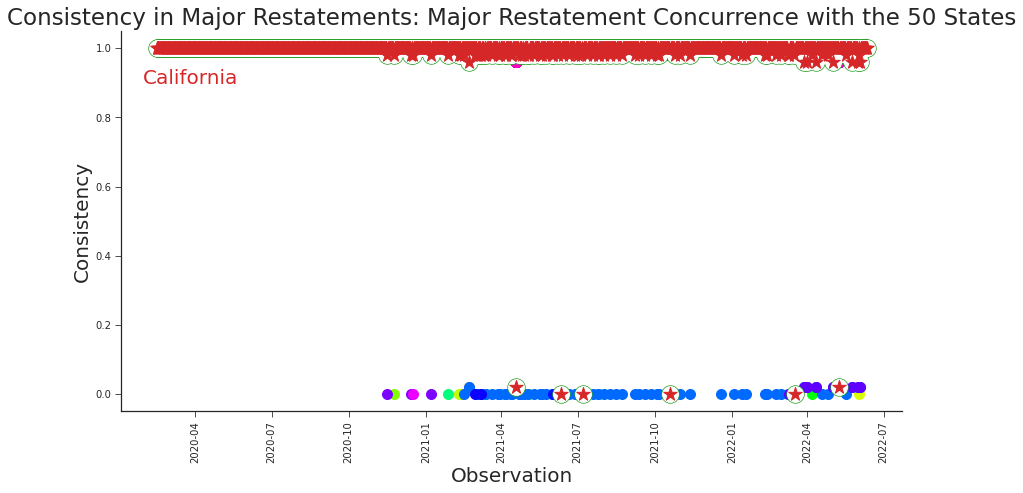

In [33]:

title = "Consistency in Major Restatements"
x_label = "Observation"
y_label = "Consistency"


plt, axs, setup_dct =  vs.setup_plot(
    cnc, title, "Major Restatement Concurrence with the 50 States", x_label, y_label,
    nrows=1, ncols=1, y_scale="linear", figsize=(14,7)
)

for i, col in enumerate(cnc.columns[:-1]):
    if col != REGION:
        plt.scatter(
            x=cnc[col][cnc[col] <= 1].index, y=cnc[col][cnc[col] <= 1],
            color=state_colors[col])

plt.text(0.15, 0.85, REGION,
    verticalalignment='bottom', horizontalalignment='right',
    transform=axs.transAxes,
    color="tab:red", fontsize=20)

plt.scatter(
    x=cnc[REGION][cnc[REGION] <= 1].index,
    y=cnc[REGION][cnc[REGION] <= 1], 
    color='tab:green', s=300)
plt.scatter(
    x=cnc[REGION][cnc[REGION] <= 1].index,
    y=cnc[REGION][cnc[REGION] <= 1], 
    color='white', s=250)
plt.scatter(
    x=cnc[REGION][cnc[REGION] <= 1].index,
    y=cnc[REGION][cnc[REGION] <= 1], 
    color="tab:red", s=200, marker='*')

plt.savefig(path.format(region=REGION, metric='consistency_concu'),  bbox_inches="tight")

# Validity

In [34]:
valid = pd.DataFrame( m.validity_all(X, df.columns), index=["validity"]).T

In [35]:
validity_df = pd.DataFrame(m.validity_group_all(arrays_dict, dfs_dict).mean(axis=1))
validity_df.columns = ['Average Across the States']
validity_df[REGION] = valid

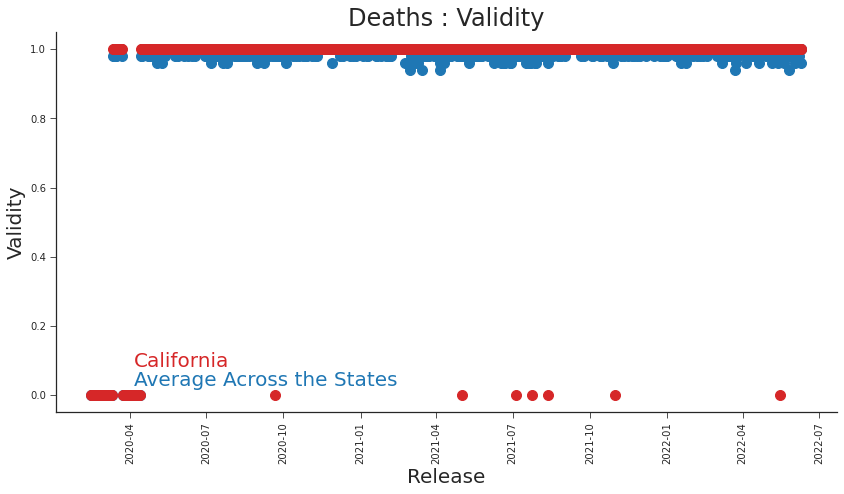

In [36]:

title = ""
x_label = "Release"
y_label = "Validity"

two_colors = ["tab:blue","tab:red"]

plt, axs, setup_dct =  vs.setup_plot(
    validity_df, title, "Validity", x_label, y_label,
    nrows=1, ncols=1, y_scale="linear", figsize=(14,7)
)

    
plt.title(label="Deaths : Validity")

for i, col in enumerate(validity_df.columns):
    plt.scatter(
        x=validity_df.index, y=validity_df[col],
        color=two_colors[i])

    plt.text(0.1, 0.06 + i*.05, col,
        verticalalignment='bottom', horizontalalignment='left',
        transform=axs.transAxes,
        color=two_colors[i], fontsize=20)

plt.savefig(path.format(region=REGION, metric='validity'),  bbox_inches="tight")

# Metrics for a Few release_dates

In [37]:
releases = [
    '2021-10-16', '2021-10-17', '2021-10-18', '2021-10-19', '2021-10-20'
]

In [38]:
release_date = RELEASE
OFFSET = '90'
AVG_COL = 'Average Across All 50 States'

In [39]:
mr_df['major_restatement'].astype(int).sum()

6

In [40]:
def report_a_release_date(release_date, offset, region=REGION):
    df = dfs_dict[region]
    X = df.to_numpy( na_value = np.nan)

    dct = OrderedDict()
    offsets = [30, 90, 150, 365]
    naive_accuracy_dm = m.naive_accuracy(X, X.shape[1] - 1)
    accuracy_dms = [ m.offset_accuracy(X, i) for i in offsets]

    col_names = [*[ f'{each}'  for each in offsets] , "latest release"]
    accuracy_df = pd.DataFrame([  *accuracy_dms, naive_accuracy_dm], columns=df.index[:-1], index=col_names ).T
    accuracy_estimates = m.accuracy_estimates_all(accuracy_df.iloc[:, :-1], accuracy_df.index)
    vals = [ m.timeliness_and_accuracy_all(X, i, .01) for i in offsets]
    col_names = [f'{offset}' for offset in offsets]
    timeliness_and_accuracy_df = pd.DataFrame(vals, columns=df.index[:-min(offsets)], index= col_names).T
    taa_estimates = m.accuracy_estimates_all(timeliness_and_accuracy_df, timeliness_and_accuracy_df.index)

    completeness_df = m.completeness_group_all({ region: arrays_dict[region]} , {region:dfs_dict[region]} )
    completeness_df.columns = [region]
    completeness_df['Average Across All 50 States'] = completeness_all_df['Completeness']
    vals = [m.completeness_and_timeliness(X[:, i], i) for i in range(1, X.shape[1]) ]
    completeness_and_timeliness_df = pd.DataFrame([vals], index=[region], columns=df.columns[1:]).T
    valid = pd.DataFrame( m.validity_all(X, df.columns), index=["validity"]).T
    validity_df = pd.DataFrame(m.validity_group_all(arrays_dict, dfs_dict).mean(axis=1))
    validity_df.columns = ['Average Across the States']
    validity_df[region] = valid

    mr_df = pd.DataFrame(major_restatements_df[major_restatements_df['region'] == region])
    mr_df.set_index('release', inplace=True)
    dct['Estimated Accuracy'] = accuracy_estimates.loc[release_date, offset] # accuracy_estimates
    dct['Estimated Accuracy SE'] = sem(accuracy_df.loc[: release_date, offset][:-int(offset)].dropna()) # accuracy_df
    dct['Estimated Timeliness and Accuracy'] =  taa_estimates.loc[release_date, offset] #taa_estimates
    dct['Estimated Timeliness and Accuracy SE'] =  sem(timeliness_and_accuracy_df.loc[:release_date, offset][:-int(offset)].dropna())
    dct['Completeness'] =  completeness_df.loc[release_date, region] 
    dct['Completeness: Average Across States'] =  completeness_df.loc[release_date, AVG_COL]
    dct['Completeness and Timeliness'] =  completeness_and_timeliness_df.loc[release_date, region]
    dct['Consistency: Restated Percent'] =  mr_df.loc[release_date, 'percent']
    dct['Consistency: Major Restatement'] =  mr_df.loc[release_date, 'major_restatement']
    dct['Consistency: Major Restatements'] = mr_df.loc[:release_date, 'major_restatement'].astype(int).sum()
    dct['Consistency: Major Restatement Concurence'] =  cnc.loc[ release_date, region]
    dct['Consistency: Across States Concurence'] =  cnc.loc[ release_date, 'group']
    dct['Validity'] = int(validity_df.loc[release_date, region])
    dct['Validity: Average Across States'] =  validity_df.loc[release_date, 'Average Across the States']
    dct['Measured Accuracy'] = int(accuracy_df.loc[release_date, offset])
    dct['Measured Timeliness and Accuracy'] =  timeliness_and_accuracy_df.loc[release_date,offset]

    index = dct.keys()

    daily_metrics = pd.DataFrame({release_date: dct})
    daily_metrics = daily_metrics.reindex(index)

    return daily_metrics

In [41]:
daily_metrics = report_a_release_date(release_date, OFFSET)
daily_metrics[release_date] = daily_metrics[release_date].map('{:,.3f}'.format)
vs.df_to_latex(daily_metrics.iloc[:-2,:], f'{REGION} {release_date} with {OFFSET} Day Offset, Measured in Real-Time')

vs.df_to_latex(daily_metrics.iloc[-2:,:], f'{REGION} {release_date} with {OFFSET} Day Offset, Measured {OFFSET} Days Later')

# Metrics for All States

In [42]:
colors = plt.cm.autumn(np.linspace(0, 1, 4))
state_colors = {state: 'blue' for state in dfs_dict.keys()}
alert_colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:pink', 'tab:pink' ,'tab:pink' ] 

for state in dfs_dict.keys():

    count = 0

    daily_metrics = report_a_release_date(release_date, OFFSET, state).T
    
    vs.df_to_latex(daily_metrics.T, f'{state} {release_date} with {OFFSET} Day Offset, Full')
    
    if abs(daily_metrics['Estimated Accuracy'][0]) > .01:
        count += 1
        
    if daily_metrics['Estimated Timeliness and Accuracy'][0] > 4:
        count += 1

    if daily_metrics['Consistency: Major Restatement'][0]:
        count += 1

    if not daily_metrics['Completeness'][0]:
        count += 1

    if not daily_metrics['Validity'][0]:
        count += 1

    state_colors[state] = alert_colors[count]


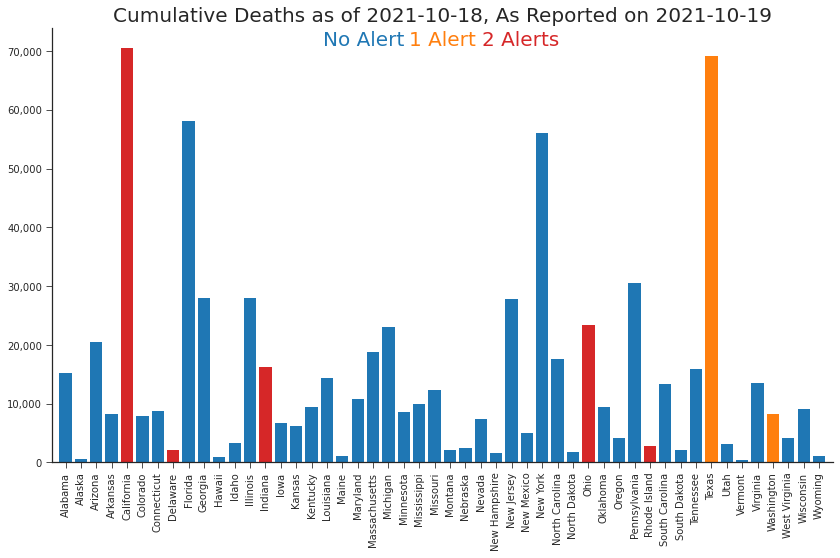

In [43]:
temp_df = pd.DataFrame(state_data).T

colors = [state_colors[state] for state in temp_df.index]
title = f'As Reported on {RELEASE}'
x_label = ""
y_label = ""

plt, axs, setup_dct =  vs.setup_plot(
    temp_df, title, f'Cumulative Deaths as of {OBSV}', x_label, y_label,
    nrows=1, ncols=1, y_scale="linear", figsize=(14,8)
)

plt.bar( x= temp_df.index, height = temp_df[OBSV], color=colors)
plt.title(label=f'Cumulative Deaths as of {OBSV}, ' + title, fontsize=20)
plt. margins(x=.01)

axs.get_yaxis().set_major_formatter(
    mtk.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.text(0.4, 0.95, 'No Alert',
    verticalalignment='bottom', horizontalalignment='center',
    transform=axs.transAxes,
    color=alert_colors[0], fontsize=20)
plt.text(0.5, 0.95, '1 Alert',
    verticalalignment='bottom', horizontalalignment='center',
    transform=axs.transAxes,
    color=alert_colors[1], fontsize=20)
plt.text(0.6, 0.95, '2 Alerts',
    verticalalignment='bottom', horizontalalignment='center',
    transform=axs.transAxes,
    color=alert_colors[2], fontsize=20)

plt.savefig(path.format(region="US_States", metric='alerts_total'),  bbox_inches="tight")

In [44]:
data_list = []
i = 0

for state, df in dfs_dict.items():
    yesterday, today = df.loc['2021-12-13','2021-12-15'], df.loc['2021-12-14', '2021-12-15']
    data_list.append([ '2021-12-15' , state, '2021-12-14', today - yesterday, today ])
    i += 0
    if i > 5:
        break


In [45]:
pd.DataFrame(data_list, columns=['Reported', 'State', 'Date', 'Net_New_Confirmed', 'Confirmed'])[:5].to_csv('states_data.csv')

# DO NOT ADD BELOW TO SCRIPT

In [46]:
import jupyckage.jupyckage as jp 
import shutil

to_latex_folder = "../latex/code/notebooks/"

notebook_name = "Metrics_CA_Deaths_JHU"

jp.notebook_to_package(f'{notebook_name}.ipynb')

shutil.copy( f'notebooks/src/{notebook_name}/{notebook_name}.py', f'{to_latex_folder}{notebook_name}.py')

'../latex/code/notebooks/Metrics_CA_Deaths_JHU.py'

In [47]:
df.columns[-1]

Timestamp('2022-06-11 00:00:00', freq='D')

In [48]:
latex_string = ""
for state in states:
    latex_string +=  R"\subsubsection{" + state + "}\n" 
    latex_string += R"\input{tables/" + state +  " 2021-10-19 with 90 Day Offset, Full.tex}\n"

In [49]:
print(latex_string)

\subsubsection{Alabama}
\input{tables/Alabama 2021-10-19 with 90 Day Offset, Full.tex}
\subsubsection{Alaska}
\input{tables/Alaska 2021-10-19 with 90 Day Offset, Full.tex}
\subsubsection{Arizona}
\input{tables/Arizona 2021-10-19 with 90 Day Offset, Full.tex}
\subsubsection{Arkansas}
\input{tables/Arkansas 2021-10-19 with 90 Day Offset, Full.tex}
\subsubsection{California}
\input{tables/California 2021-10-19 with 90 Day Offset, Full.tex}
\subsubsection{Colorado}
\input{tables/Colorado 2021-10-19 with 90 Day Offset, Full.tex}
\subsubsection{Connecticut}
\input{tables/Connecticut 2021-10-19 with 90 Day Offset, Full.tex}
\subsubsection{Delaware}
\input{tables/Delaware 2021-10-19 with 90 Day Offset, Full.tex}
\subsubsection{Florida}
\input{tables/Florida 2021-10-19 with 90 Day Offset, Full.tex}
\subsubsection{Georgia}
\input{tables/Georgia 2021-10-19 with 90 Day Offset, Full.tex}
\subsubsection{Hawaii}
\input{tables/Hawaii 2021-10-19 with 90 Day Offset, Full.tex}
\subsubsection{Idaho}
\inpu